## DM-19292: Compare detection rates to Gaussian noise for HiTS processing

In [1]:
import os
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.geom
afwDisplay.setDefaultBackend('matplotlib')
import matplotlib.ticker as plticker
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)

This analysis repeats the relevant portions of the [DMTN-006](https://dmtn-006.lsst.io/) & [DMTN-021](https://dmtn-021.lsst.io/) analysis of DIASource detection rates for our current HiTS processing to bound our false positive rates.

In [2]:
# Meredith's standard processing location
#REPO = '/project/mrawls/hits2015/rerun/cw_processed3'
REPO = '/project/mrawls/hits2015/rerun/cw_processed4' #with updated PhotoCalib configs 

# with decorrelation off
#/project/mrawls/hits2015/rerun/cw_nodecorr1

In [3]:
connection = sqlite3.connect(f'{REPO}/association.db')

Take a look at the DiaSource table:

In [4]:
ds_sample = pd.read_sql_query('select * from DiaSource LIMIT 10;', connection)

In [5]:
ds_sample

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,ixxPSF,iyyPSF,ixyPSF,extendedness,spuriousness,flags,pixelId,filterName,filterId,isDipole
0,176486811852341337,41091538,176486811852341337,0,0,0,None,57070.141866,150.908070,None,...,3.568572,4.375425,-0.412995,None,None,268,0,g,1,0
1,176486811852341338,41091538,176486811852341338,0,0,0,None,57070.141866,150.912628,None,...,3.568572,4.375425,-0.412995,None,None,0,0,g,1,0
2,176486811852341339,41091538,176486811852341339,0,0,0,None,57070.141866,150.917767,None,...,3.568572,4.375425,-0.412995,None,None,25165824,0,g,1,1
3,176486811852341340,41091538,176486811852341340,0,0,0,None,57070.141866,150.918168,None,...,3.568572,4.375425,-0.412995,None,None,1320,0,g,1,0
4,176486811852341341,41091538,176486811852341341,0,0,0,None,57070.141866,150.924709,None,...,3.568572,4.375425,-0.412995,None,None,41943900,0,g,1,0
5,176486811852341342,41091538,176486811852341342,0,0,0,None,57070.141866,150.937029,None,...,3.568572,4.375425,-0.412995,None,None,25166844,0,g,1,0
6,176486811852341343,41091538,176486811852341343,0,0,0,None,57070.141866,150.933536,None,...,3.568572,4.375425,-0.412995,None,None,109051976,0,g,1,1
7,176486811852341344,41091538,176486811852341344,0,0,0,None,57070.141866,150.936417,None,...,3.568572,4.375425,-0.412995,None,None,0,0,g,1,1
8,176486811852341345,41091538,176486811852341345,0,0,0,None,57070.141866,150.936867,None,...,3.568572,4.375425,-0.412995,None,None,25165824,0,g,1,1
9,176486811852341346,41091538,176486811852341346,0,0,0,None,57070.141866,150.947150,None,...,3.568572,4.375425,-0.412995,None,None,396,0,g,1,0


How many unique ccdVisits do we have?

In [6]:
pd.read_sql_query('select COUNT(DISTINCT ccdVisitId) from DiaSource;', connection)

,COUNT(DISTINCT ccdVisitId)
0,5011


Load all of the data

In [7]:
ds = pd.read_sql_query('select ccdVisitId, psFlux, psFluxErr from DiaSource;', connection)

How many positive and negative DIASources are there?

In [8]:
print('Number of positive DIASource detections: ',np.sum(ds.psFlux > 0))
print('Number of negative DIASource detections: ',np.sum(ds.psFlux < 0))

Number of positive DIASource detections:  599327
Number of negative DIASource detections:  449000


What is the measured (!= detected) SNR of the DIASources?

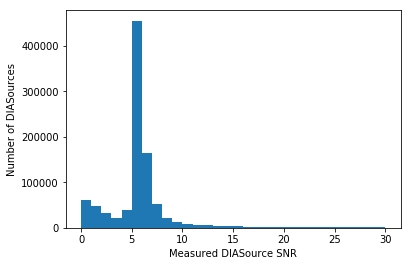

In [9]:
_=plt.hist(np.abs(ds.psFlux)/ds.psFluxErr,bins=np.linspace(0,30,31))
_=plt.xlabel("Measured DIASource SNR")
_=plt.ylabel("Number of DIASources")

How many DIASources are there per ccdVisit?

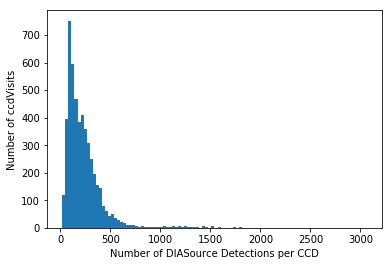

In [10]:
vgrp = ds.groupby('ccdVisitId')
nDiaSources = vgrp['psFlux'].agg(len)
_=plt.hist(nDiaSources,bins=100)
_=plt.xlabel("Number of DIASource Detections per CCD")
_=plt.ylabel("Number of ccdVisits")

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


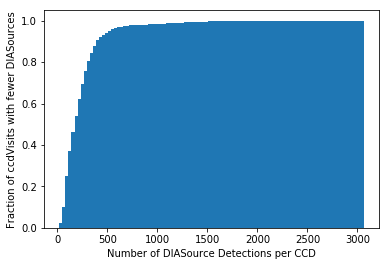

In [11]:
_=plt.hist(nDiaSources,bins=100, cumulative=True,normed=True)
_=plt.xlabel("Number of DIASource Detections per CCD")
_=plt.ylabel("Fraction of ccdVisits with fewer DIASources")

In [12]:
np.percentile(nDiaSources,[10,50,90])

array([ 79., 185., 410.])

So these are much worse than the ~50 DIASource detections reported at 5 sigma with decorrelation on in DMTN-021.

How many sources would we expect per CCD if Gaussian noise was the only source of detections? (This is of course unrealistic, as there are real astrophysical variables present.  We do not yet have these catalogued, however.)

via https://github.com/lsst-dm/diffimTests/blob/master/notebooks/20.%20compare%20photometry-corrected-many-DECam-images.ipynb

In [13]:
def noise_detections(nu, sigma_g=1.8, npix=2000.*4000):
    out = nu * np.exp(-(nu**2.)/2) / (2.**(5./2.) * np.pi**(3./2.))
    out *= 1. / sigma_g**2. * npix
    return out

In [14]:
noise_detections(5) # reproducing DMTN-006 calculation for DECam

1.4606096281552305

Where are the really bad images?

In [15]:
wbad = nDiaSources > 2000
np.sum(wbad)

7

In [16]:
nDiaSources[wbad]

ccdVisitId
41137103    3062.0
41979116    2198.0
41980411    2074.0
41980415    2501.0
41980416    2632.0
41980440    2226.0
41980447    2482.0
Name: psFlux, dtype: float64

### Potential Future Work

* get actual seeing per image and calculate excess detection rate 
* reproduce DMTN-006/021 plots